### Singapore F1 Grand Prix Dates and Data Collection

The Singapore F1 Grand Prix took place on the following dates:

- **2017**: 15th September to 17th September
- **2018**: 14th September to 16th September
- **2019**: 20th September to 22nd September
- **2022**: 30th September to 2nd October
- **2023**: 15th September to 17th September

We are in the process of collecting data for the 2023 Grand Prix. Please note that the data for the last weekend of the event in 2023 has not been recorded yet. We will wait until January 2nd to gather the complete dataset for analysis purposes.

Data has been collected between 6 PM and 10 PM on Saturdays and Sundays for each weekend of the year.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Collecting Energy Demand Data for 2023

In [10]:
def get_weektable_from_excel(date:str, demand:str):
    """
    NOTE: WORKS FOR TABLES FROM 29 SEP 2014 ONWARDS ONLY

    date = DD/MM/YYYY format -- first date of the week, by which the file is stored on ema.gov.sg

    demand = ['system', 'nem_actual', 'nem_forecast']
    """
    import pandas as pd
    import time as tm

    # base_url + year/ + ['20141222','29_Sep_2014'] + .xls
    base_url = "https://www.ema.gov.sg/content/dam/corporate/resources/statistics/half-hourly-data/"
    date_tm = tm.strptime(date,"%d/%m/%Y")
    
    try:
        tempdf = pd.read_excel(base_url + tm.strftime("%Y/%Y%m%d.xls",date_tm), index_col=0, header=[1,4]).iloc[:48]
    except:
        try:
            tempdf = pd.read_excel(base_url + tm.strftime("%Y/%d_%b_%Y.xls",date_tm), index_col=0, header=[1,4]).iloc[:48]
        except:
            # 02 Jan 2017 error
            tempdf = pd.read_excel('https://www.ema.gov.sg/content/dam/corporate/resources/statistics/half-hourly-data/2016/20170102.xls', index_col=0, header=[1,4]).iloc[:48]
    
    demand_in = ['system','nem_actual','nem_forecast']
    demand_out = [' System Demand (Actual)',' NEM Demand (Actual)',' NEM Demand (Forecast)']
    if demand == demand_in[0]:
        try:
            return tempdf.xs(demand_out[0], axis=1, level=1)
        except:
            print('No system demand column!')
    elif demand == demand_in[1]:
        try:
            return tempdf.xs(demand_out[1], axis=1, level=1)
        except:
            return tempdf.xs('NEM Demand ', axis=1, level=1)
    elif demand == demand_in[2]:
        try:
            return tempdf.xs(demand_out[2], axis=1, level=1)
        except:
            return tempdf.xs('VSTLF', axis=1, level=1)

def yearly_excel(startdate:str, enddate:str, demand:str):
    import pandas as pd
    import time as tm
    import datetime as dt

    startdate_tm = tm.strptime(startdate,"%d/%m/%Y")
    enddate_tm = tm.strptime(enddate,"%d/%m/%Y")
    delta = dt.timedelta(days = 7)

    currdate_tm = startdate_tm
    tempdf = get_weektable_from_excel(date=tm.strftime('%d/%m/%Y',currdate_tm), demand=demand)

    #updating
    prev_df = tempdf
    prev_date = currdate_tm
    currdate_tm = dt.datetime(currdate_tm[0],currdate_tm[1],currdate_tm[2])
    currdate_tm += delta
    currdate_tm = currdate_tm.timetuple()

    while (currdate_tm <= enddate_tm):
        tempdf = get_weektable_from_excel(date=tm.strftime('%d/%m/%Y',currdate_tm), demand=demand)

        #adding to dataframes according to years
        if (currdate_tm.tm_year == prev_date.tm_year):
            prev_df = pd.concat([prev_df,tempdf], axis=1)
        # else:
        #     #save prev_df in excel with prev year name
        #     prev_df.columns = prev_df.columns.strftime("%d/%m/%Y")
        #     prev_df.to_excel(str(prev_date.tm_year) + f'[{demand}]' + ".xlsx")
        #     prev_df = tempdf

        #updating
        prev_date = currdate_tm
        currdate_tm = dt.datetime(currdate_tm[0],currdate_tm[1],currdate_tm[2])
        currdate_tm += delta
        currdate_tm = currdate_tm.timetuple()
    prev_df.columns = prev_df.columns.strftime("%d/%m/%Y")
    prev_df.to_excel(str(prev_date.tm_year) + f'[{demand}]' + ".xlsx")

In [11]:
yearly_excel('02/01/2023','25/12/2023','system')

Data Collection

In [13]:
def weekendfone(year):
    df = pd.read_excel(f'Yearly Energy Demand Data/System Demand (Actual)/{year}.xlsx', index_col=0)
    df.columns = pd.to_datetime(df.columns, dayfirst=True)
    saturdays = {}
    sundays  = {}
    for i in df.columns:
        if i.weekday() == 5:
            saturdays[i] = sum(df[i]['18:30':'22:00'])
        elif i.weekday() == 6:
            sundays[i] = sum(df[i]['18:30':'22:00'])
        
    saturdays = pd.Series(saturdays)
    sundays = pd.Series(sundays)

    i_sm = {1: 0.9579037796074662,
        2: 0.9596186164365493,
        3: 0.9898073559402792,
        4: 1.0030397134620446,
        5: 1.018392643199991,
        6: 1.0261222064430728,
        7: 1.02305328000198,
        8: 1.017260959899729,
        9: 1.020519376655325,
        10: 1.011875522378184,
        11: 0.9942104067376999,
        12: 0.976059327973805}

    weekends = {}

    for i in range(len(saturdays)):
        weekends[saturdays.index[i].strftime("%d%b") +'-'+ sundays.index[i].strftime("%d%b")] = saturdays[i] + sundays[i]

    weekends = pd.Series(weekends)
    deseasonalized = weekends.copy()
    
    for i in range(len(saturdays)):
        deseasonalized.iloc[i] = deseasonalized.iloc[i] / i_sm[saturdays.index[i].month]

    #deseasonalized.plot(xticks=range(len(deseasonalized)), rot=90, figsize=(20,10), grid=True, title=f'Deseasonalized Weekend 18:00-22:00 Energy Demand for {year}')
    deseasonalized.to_excel(f'{year} Weekendfone.xlsx')

In [4]:
for year in [2017,2018,2019,2021,2022,2023]:
    weekendfone(year)

Data Viz

In [1]:
# for year in [2017,2018,2019,2022,2023]:
#     df = pd.read_excel('DeseasonalizedWeekendsF1.xlsx', index_col=0, sheet_name=str(year))
#     df.plot(xticks=range(len(df)), rot=90, figsize=(20,10), grid=True, title=f'Deseasonalized Weekend 18:00-22:00 Energy Demand for {year}')

In [7]:
data = {}
for year in [2017,2018,2019,2022,2023]:
    df = pd.read_excel('DeseasonalizedWeekendsF1.xlsx', sheet_name=str(year), index_col=0)
    df.columns = ['Demand']
    data[year] = df

f_one = {
    2017: '16Sep-17Sep',
    2018: '15Sep-16Sep',
    2019: '21Sep-22Sep',
    2022: '01Oct-02Oct',
    2023: '16Sep-17Sep'
}

In [23]:
def controlchart(data,year):
    mean = np.mean(data[year]['Demand'])
    std = np.std(data[year]['Demand'])  
    ucl = mean + 3*std
    lcl = mean - 3*std

    plt.figure(figsize=(20, 10))
    plt.plot(data[year].index, data[year]['Demand'])
    plt.scatter(f_one[year], data[year].loc[f_one[year]], color='purple', label = 'F1 Weekend')
    plt.axhline(mean, color='green', label='Mean')
    plt.axhline(ucl, color='red', label='UCL')
    plt.axhline(lcl, color='red', label='LCL')
    plt.title(f'Deseasonalized Weekend 18:00-22:00 Energy Demand for {year}')
    # plt.xlabel('Date')
    plt.ylabel('Demand (KWh)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.savefig(f'F1 Control Chart {year}.png')

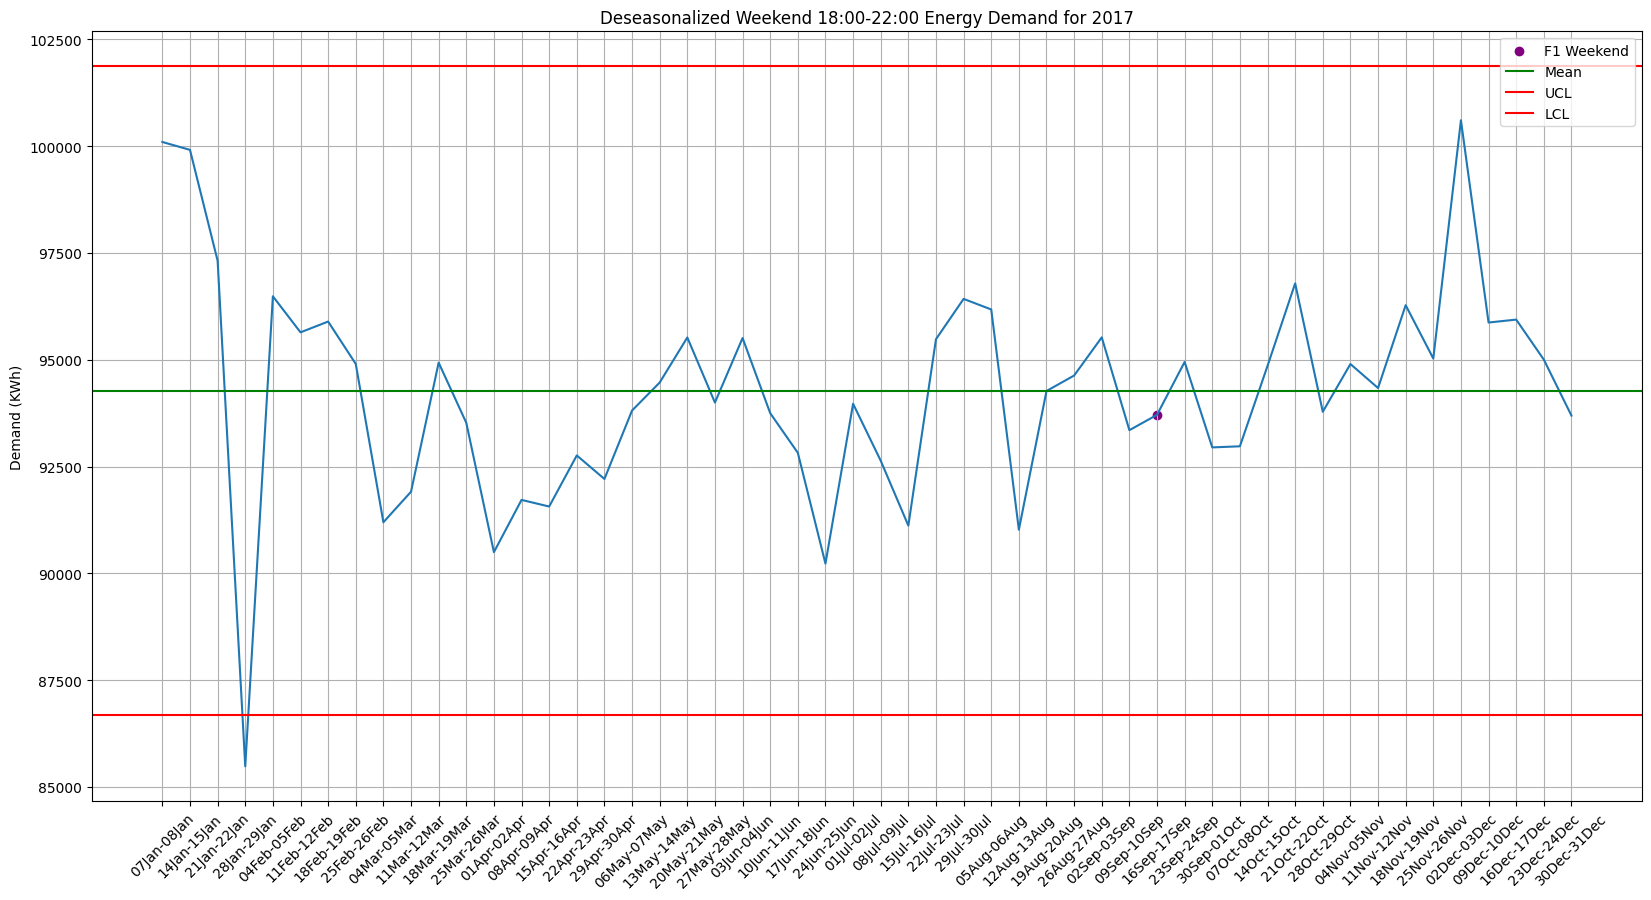

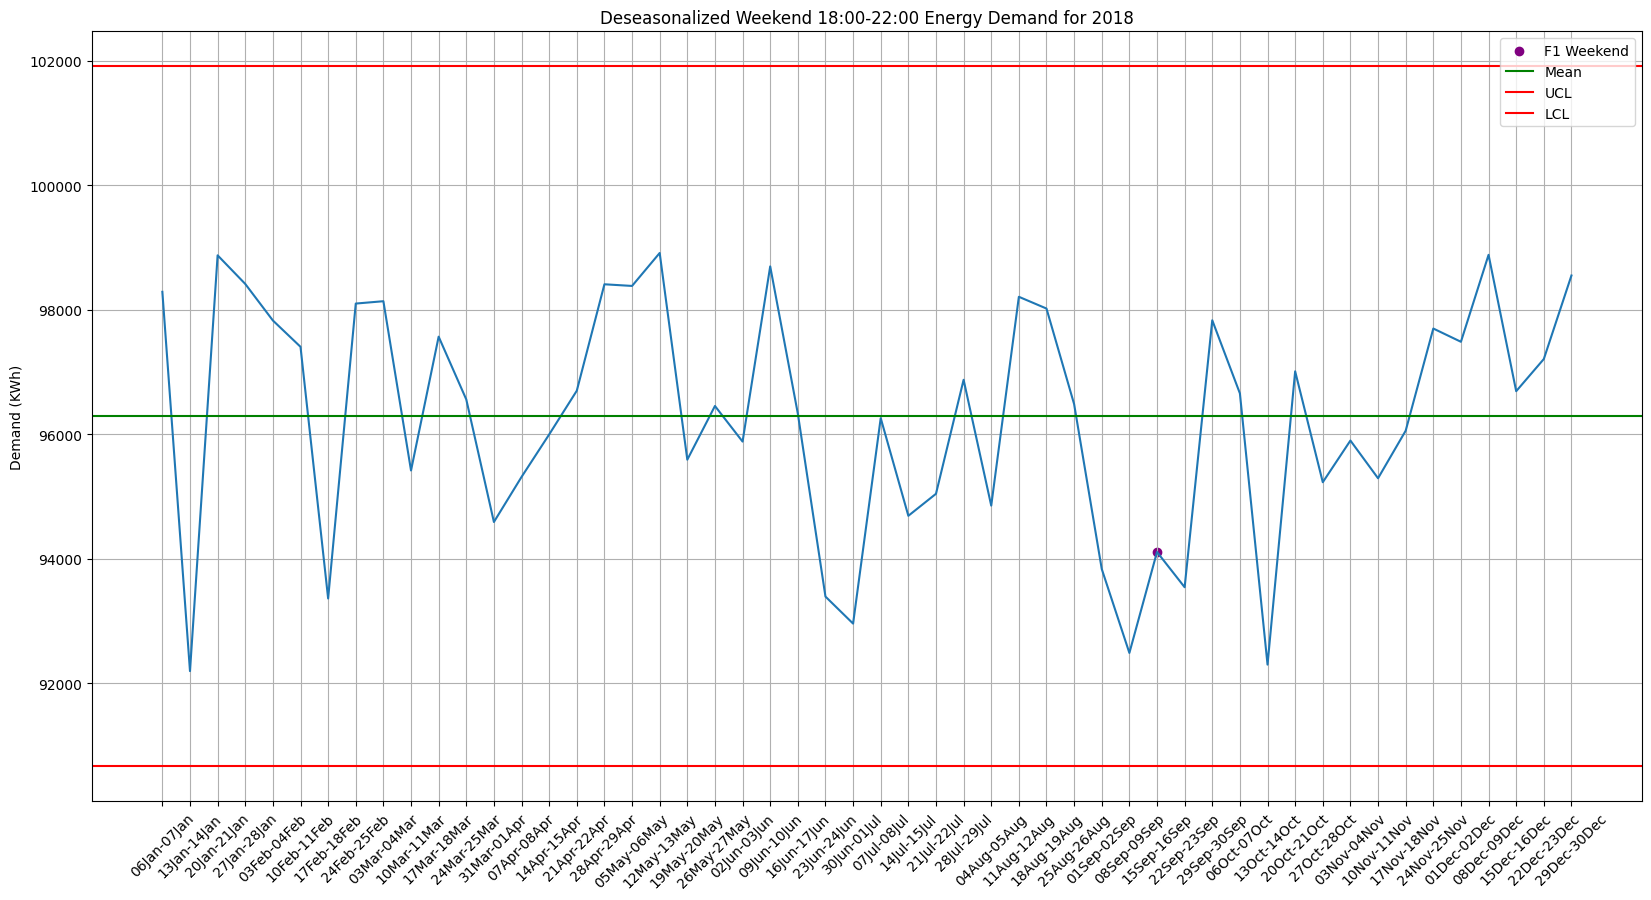

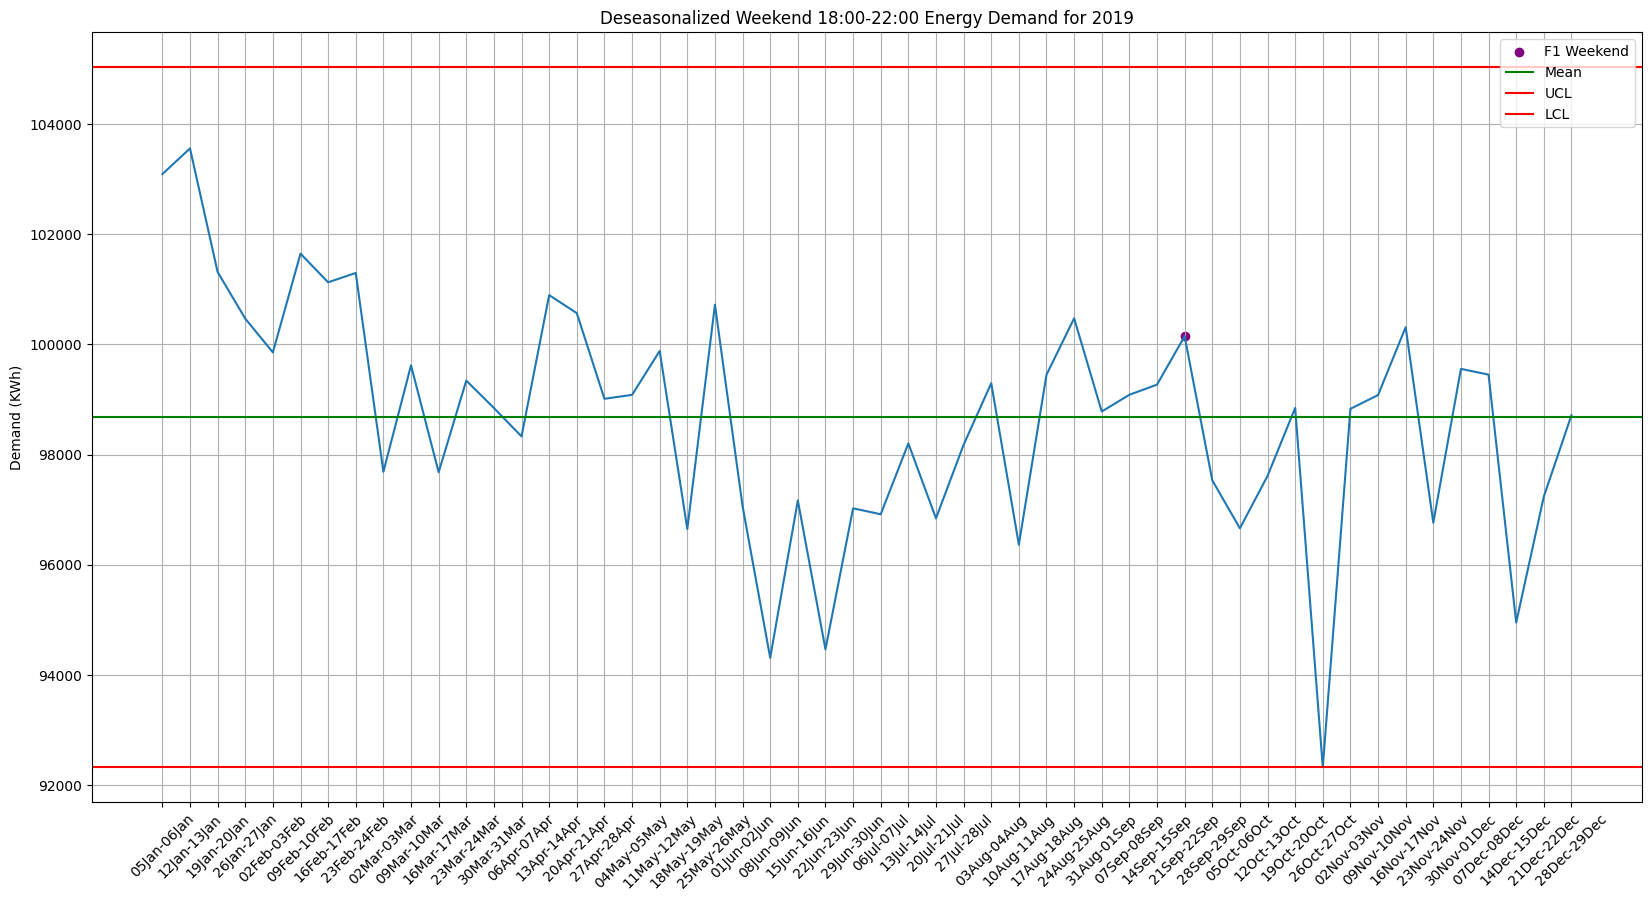

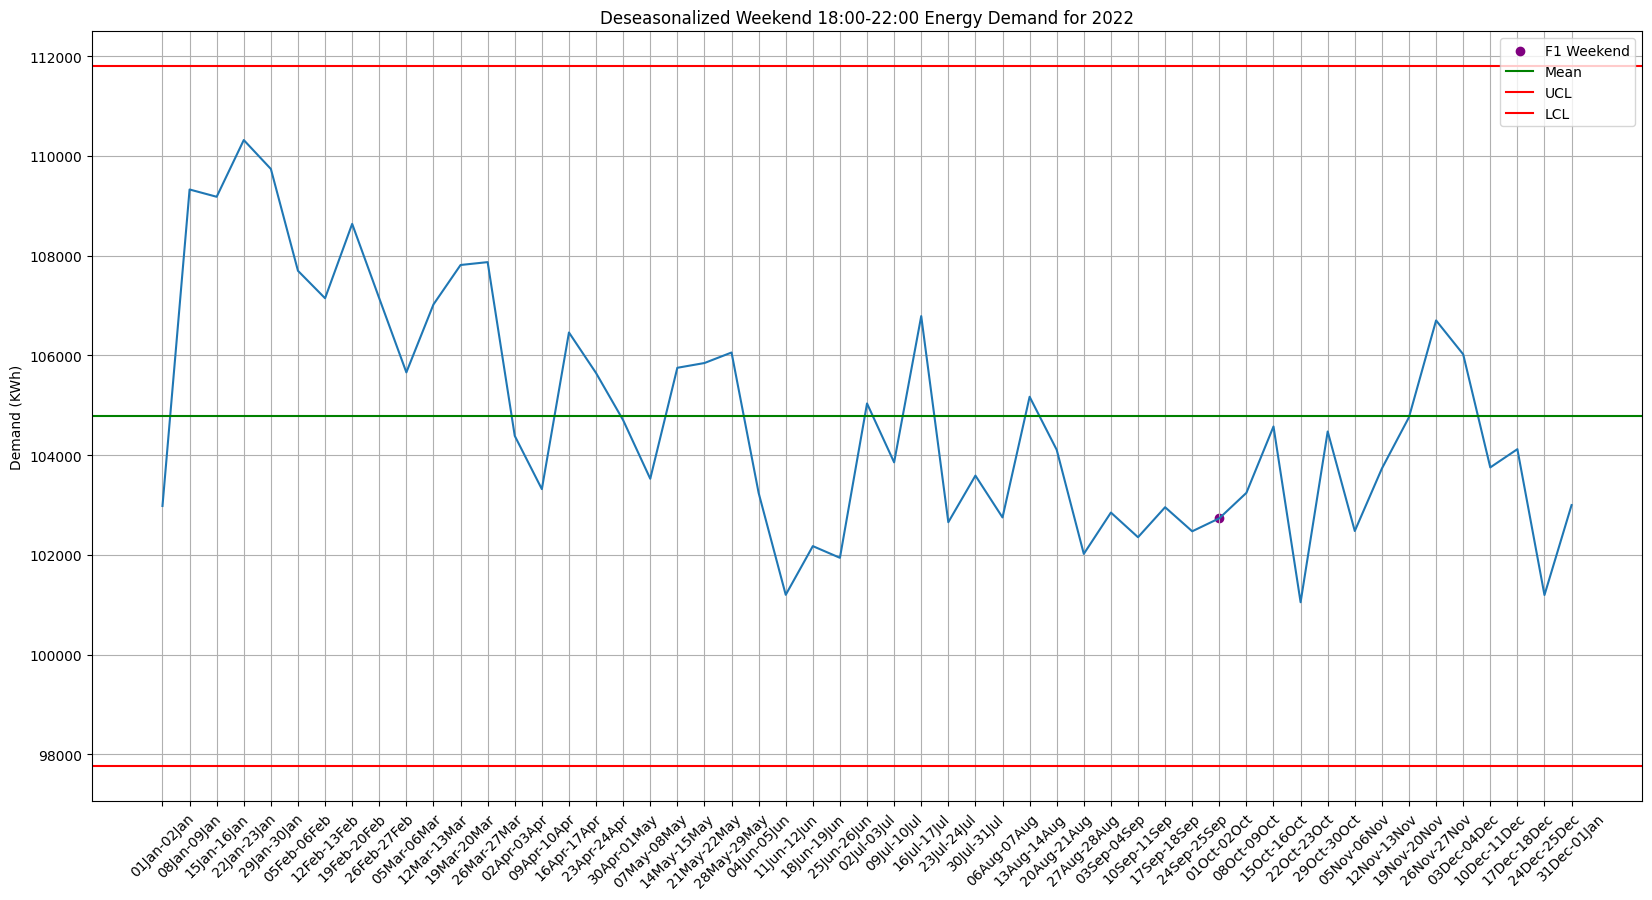

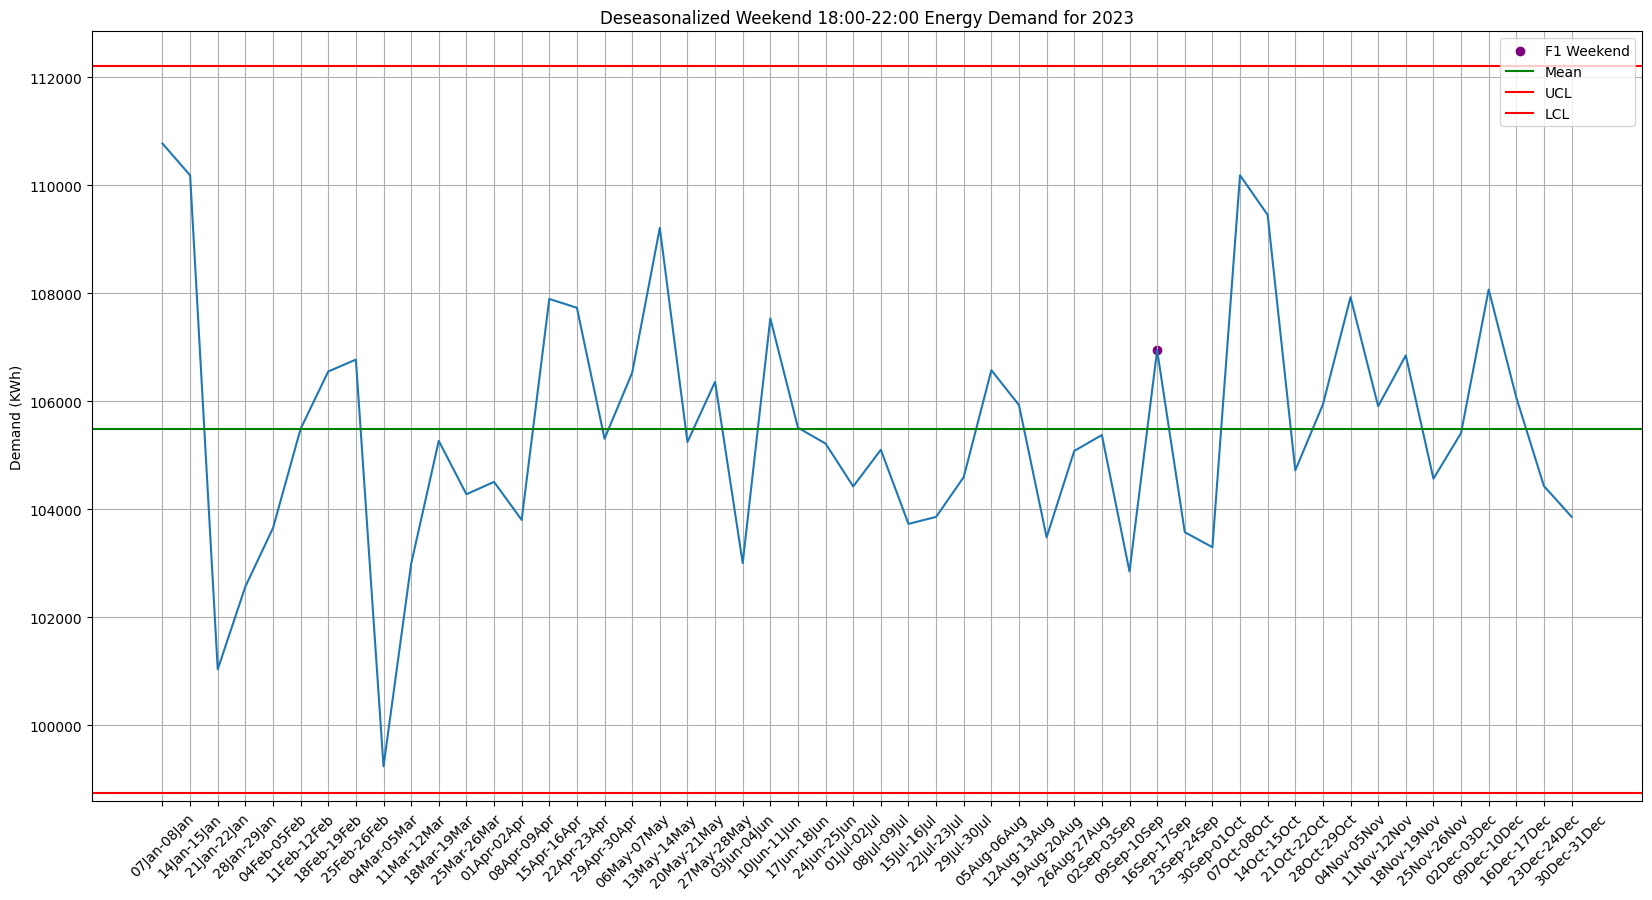

In [24]:
controlchart(data,2017)
controlchart(data,2018)
controlchart(data,2019)
controlchart(data,2022)
controlchart(data,2023)

In [26]:
indices = [i+'-'+str(2017) for i in data[2017].index]
collectdf = pd.DataFrame(data[2017].values,index=indices, columns=['Demand'])

for year in [2018,2019,2022,2023]:
    indices = [i+'-'+str(year) for i in data[year].index]
    collectdf = collectdf.append(pd.DataFrame(data[year].values,index=indices, columns=['Demand']))
collectdf

C:\Users\Ayush\AppData\Local\Temp\ipykernel_19240\1628736593.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collectdf = collectdf.append(pd.DataFrame(data[year].values,index=indices, columns=['Demand']))
C:\Users\Ayush\AppData\Local\Temp\ipykernel_19240\1628736593.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collectdf = collectdf.append(pd.DataFrame(data[year].values,index=indices, columns=['Demand']))
C:\Users\Ayush\AppData\Local\Temp\ipykernel_19240\1628736593.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  collectdf = collectdf.append(pd.DataFrame(data[year].values,index=indices, columns=['Demand']))
C:\Users\Ayush\AppData\Local\Temp\ipykernel_19240\1628736593.py:6: FutureWarning: The frame.append method 

,Demand
07Jan-08Jan-2017,100096.681061
14Jan-15Jan-2017,99911.883819
21Jan-22Jan-2017,97317.102458
28Jan-29Jan-2017,85483.588883
04Feb-05Feb-2017,96485.354097
...,...
02Dec-03Dec-2023,105411.291683
09Dec-10Dec-2023,108067.328737
16Dec-17Dec-2023,106068.008301
23Dec-24Dec-2023,104430.117147


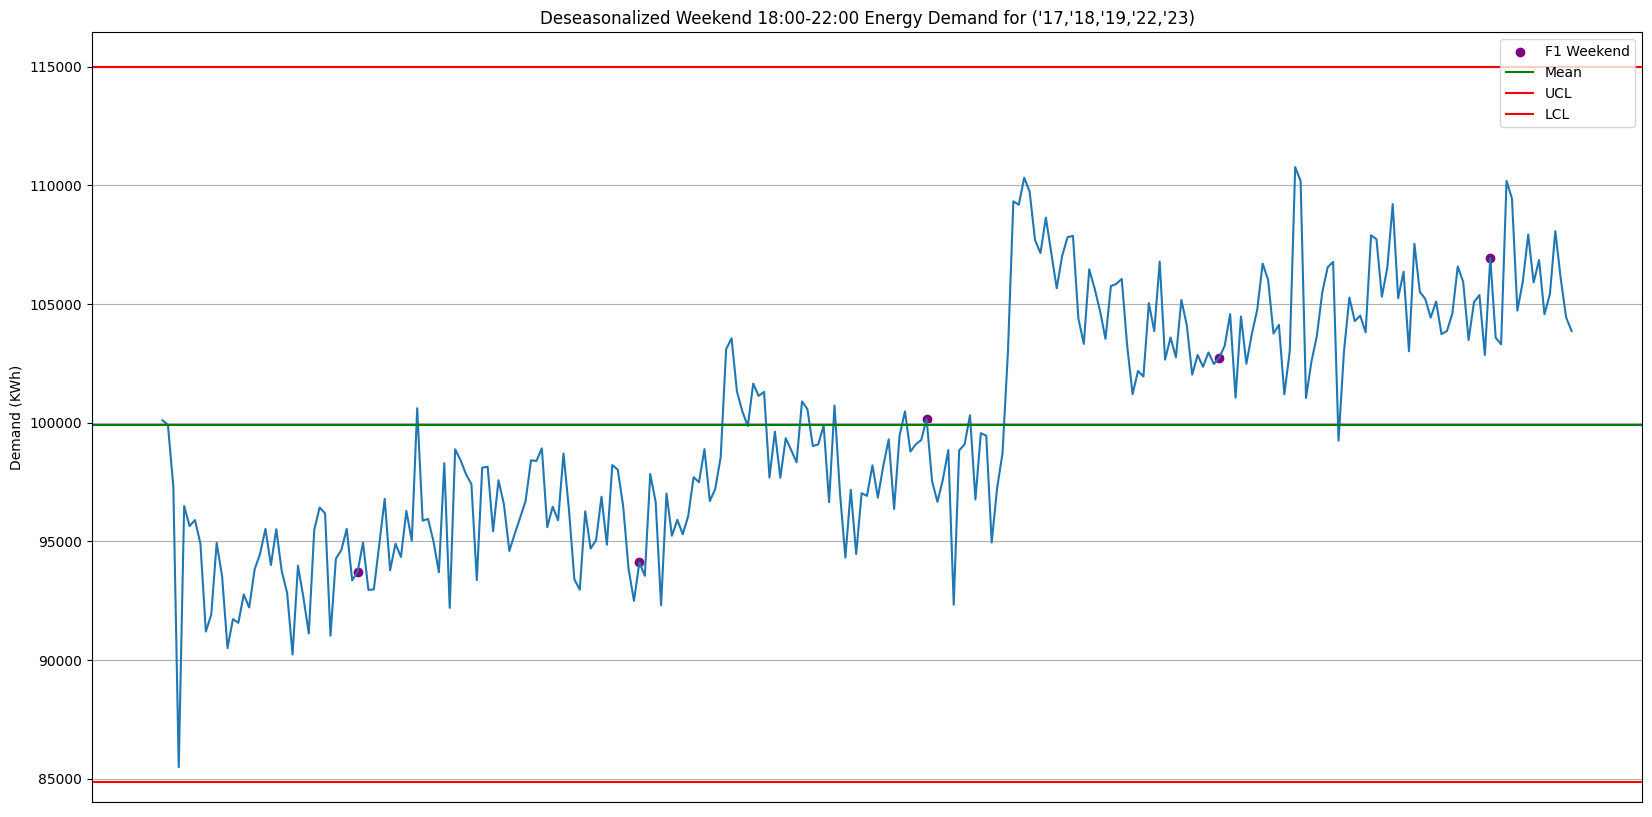

In [31]:
mean = np.mean(collectdf['Demand'])
std = np.std(collectdf['Demand'])  
ucl = mean + 3*std
lcl = mean - 3*std

plt.figure(figsize=(20, 10))
plt.plot(collectdf.index, collectdf['Demand'])
plt.scatter([f_one[year] + f'-{year}' for year in [2017,2018,2019,2022,2023]], [collectdf.loc[f_one[year] + f'-{year}'] for year in [2017,2018,2019,2022,2023]], color='purple', label = 'F1 Weekend')
plt.axhline(mean, color='green', label='Mean')
plt.axhline(ucl, color='red', label='UCL')
plt.axhline(lcl, color='red', label='LCL')
plt.title("Deseasonalized Weekend 18:00-22:00 Energy Demand for ('17,'18,'19,'22,'23)")
# plt.xlabel('Date')
plt.ylabel('Demand (KWh)')
plt.xticks([])
plt.grid()
plt.legend()
plt.savefig("F1 Control Chart ('17,'18,'19,'22,'23).png")